The traffic light is YELLOW
Time tensor flow boot and classification:  5.710916996002197 s

The traffic light is YELLOW
Time classification only:  0.09467482566833496 s



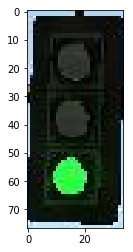

In [21]:
import tensorflow as tf
import numpy as np
import cv2

# only for testing/plotting -> dont introduce in ROS node
from matplotlib import pyplot as plt
import time

# parameters
PATH_TO_CKPT = 'ssd_mobilenet_v1_coco_2017_11_17.pb'

TEST_IMAGE_PATH = 'green_example.png'
#TEST_IMAGE_PATH = 'yellow_example.png'
#TEST_IMAGE_PATH = 'red_example.png'

class TLClassifier(object):
    def __init__(self):
        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
          od_graph_def = tf.GraphDef()
          with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
            
        self.sess = None
        self.setup = False
        self.tensor_dict = None
        self.image_tensor = None

    def get_classification(self, image):
        # detection call
        output = self.run_inference_for_single_image(image)
        
        # only for testing/plotting -> dont introduce in ROS node
        CLASS_TRAFFIC_LIGHT = 10
        THRESHOLD_SCORE = 0.8
        %matplotlib inline
        
        boxes = output['detection_boxes']
        classes =  output['detection_classes']
        scores = output['detection_scores']
        
        img = cv2.imread(TEST_IMAGE_PATH)
        height, width = img.shape[:2]
        
        idxTL = np.where(classes == CLASS_TRAFFIC_LIGHT)  
        
        bestThresh = THRESHOLD_SCORE
        match = None
            
        for i in idxTL[0].tolist():
            if scores[i] > THRESHOLD_SCORE and scores[i] > bestThresh:
                match = i
                bestThresh = scores[i]
        
        if match is not None:
            # extract/crop region of interest and plot
            right_y = int(boxes[match][0]*height)
            left_y = int(boxes[match][2]*height)
            left_x = int(boxes[match][1]*width)
            right_x = int(boxes[match][3]*width)
                  
            roi = img[right_y:left_y, left_x:right_x]
            cv2.imwrite('/home/bruno/analyze.png',roi)
            
            result = self.red_green_yellow(roi)
            roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
            
            plt.imshow(roi)
            
            print('The traffic light is', result)
        else:
            print('No traffic light detected')

        return None

    
    def run_inference_for_single_image(self, image):
      with self.detection_graph.as_default():
        if (self.setup == False):
            with tf.Session() as self.sess:
              # Get handles to input and output tensors
              ops = tf.get_default_graph().get_operations()
              all_tensor_names = {output.name for op in ops for output in op.outputs}
              self.tensor_dict = {}
              for key in [
                  'num_detections', 'detection_boxes', 'detection_scores',
                  'detection_classes', 'detection_masks'
              ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                  self.tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                      tensor_name)
              if 'detection_masks' in self.tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(self.tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(self.tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(self.tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                self.tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
              self.image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
              self.setup = True
        
    
        if (self.setup == True):
            # Run inference
            output_dict = self.sess.run(self.tensor_dict,feed_dict={self.image_tensor: np.expand_dims(image, 0)})
        
            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
                return output_dict
        
        return output_dict
    
    
    def findNonZero(self, image_in):
      rows, cols, _ = image_in.shape
      counter = 0
    
      for row in range(rows):
        for col in range(cols):
          pixel = image_in[row, col]
          if sum(pixel) != 0:
            counter = counter + 1
    
      return counter

    # Taken and adapted from: https://github.com/thedch/traffic-light-classifier?files=1
    def red_green_yellow(self, image_in):
      hsv = cv2.cvtColor(image_in, cv2.COLOR_BGR2HSV)

      sum_saturation = np.sum(hsv[:,:,1]) # Sum the brightness values
      height, width = hsv.shape[:2] 
      area = height*width
      avg_saturation = sum_saturation / area # Find the average
    
      sat_low = int(avg_saturation * 1.3)
      val_low = 140
    
      # Green
      lower_green = np.array([70,sat_low,val_low])
      upper_green = np.array([100,255,255])
      green_mask = cv2.inRange(hsv, lower_green, upper_green)
      green_result = cv2.bitwise_and(image_in, image_in, mask = green_mask)
    
      # Yellow
      lower_yellow = np.array([10,sat_low,val_low])
      upper_yellow = np.array([60,255,255])
      yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
      yellow_result = cv2.bitwise_and(image_in, image_in, mask = yellow_mask)
    
      # Red
      lower_red = np.array([150,sat_low,val_low])
      upper_red = np.array([180,255,255])
      red_mask = cv2.inRange(hsv, lower_red, upper_red)
      red_result = cv2.bitwise_and(image_in, image_in, mask = red_mask)
    
      sum_green = self.findNonZero(green_result)
      sum_yellow = self.findNonZero(yellow_result)
      sum_red = self.findNonZero(red_result)
    
      if sum_red >= sum_yellow and sum_red >= sum_green:
        return 'RED'
      if sum_yellow >= sum_green:
        return 'YELLOW' 
      return 'GREEN' 

        
# Sample calls with timing info
t = time.time()
cvimage = cv2.imread(TEST_IMAGE_PATH)
cvimage = cvimage[...,::-1]
(im_height, im_width) = cvimage.shape[:2]
npimage = np.array(cvimage.reshape(im_height, im_width, 3)).astype(np.uint8)        
classifier = TLClassifier() 
classifier.get_classification(npimage)
elapsed = time.time() - t
print('Time tensor flow boot and classification: ', elapsed, 's\n')

t = time.time()
cvimage = cv2.imread(TEST_IMAGE_PATH)
cvimage = cvimage[...,::-1]
(im_height, im_width) = cvimage.shape[:2]
npimage = np.array(cvimage.reshape(im_height, im_width, 3)).astype(np.uint8)        
classifier.get_classification(npimage)
elapsed = time.time() - t
print('Time classification only: ', elapsed,'s\n')